# Load and model data

## import necessary packages

In [75]:
import sys
sys.path.insert(1, '/Users/allisonhonold/ds0805/walk_proj/walk_risk_engine/python')
from modeling import categorize_arrests, split_last, joblib_pipeline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data from sql database

In [2]:
df = pd.read_sql_query("""
                        SELECT latitude, 
                                longitude, 
                                ap_t_high100, 
                                n_arrests
                        FROM manhattan_loc_d_ar_wea 
                        ;"""
                        , 'postgresql:///walk')

## initial data cleaning and train / evaluation split
1) categorize arrests into 0: zero arrests, and 1: 1+ arrests  
2) add latlong feature  
3) split train / evaluation set temporally

In [3]:
categorized_df = categorize_arrests(df)

In [4]:
# add combined lat/long location feature
categorized_df['latlong'] = (categorized_df['latitude'].astype(str) 
                            + categorized_df['longitude'].astype(str))

In [28]:
X, y, X_eval, y_eval = split_last(categorized_df, target_col='n_arrests',
                                                  sort_col=None, cut=.8)

## Nieve Log Loss as baseline

In [34]:
preds = np.zeros(y.shape[0])
preds[0]=1

In [35]:
log_loss(y_train_test, preds)

1.0406075360295546

## Modeling based on temp, lat/long
train test split to allow for evaluation w/out the time needed for cross validation, also avoiding overfitting on evaluation data set.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, random_state=0)

In [36]:
column_transformer = ColumnTransformer( 
    transformers=[
    ('ohe', OneHotEncoder(categories='auto'), ['latlong']),
    ('ss', StandardScaler(), ['latitude', 'longitude', 'ap_t_high100']),
    ], remainder='drop')

### Logistic Regression

In [37]:
lr_model = LogisticRegression(random_state=0, solver='sag')

In [38]:
lr_pipe = Pipeline([
                    ('preprocessor', column_transformer),
                    ('model', lr_model)
                ])

In [39]:
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['latlong']),
                                                 ('

In [40]:
train_probas = lr_pipe.predict_proba(X_train)
test_probas = lr_pipe.predict_proba(X_test)

In [41]:
print(f"training log loss: {log_loss(y_train, train_probas)}") 
print(f"test log loss: {log_loss(y_test, test_probas)}")

training log loss: 0.09540030887574136
test log loss: 0.0953859079702493


### Random Forest

In [61]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=2000)

In [62]:
rf_pipe = Pipeline([
                        ('preprocessor', column_transformer),
                        ('model', rfc)
                    ])

In [63]:
rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['latlong']),
                                                 ('

In [64]:
train_probas = rf_pipe.predict_proba(X_train)
test_probas = rf_pipe.predict_proba(X_test)

In [65]:
print(f"training log loss: {log_loss(y_train, train_probas)}") 
print(f"test log loss: {log_loss(y_test, test_probas)}")

training log loss: 0.13038550540208885
test log loss: 0.13031261907166952


## Investigate predictions from Logistic Regression

In [67]:
preds = lr_pipe.predict_proba(test_data)

In [68]:
probas = pd.Series(preds[:, 1], name='Probability')

In [71]:
from matplotlib import pyplot as plt
%matplotlib inline

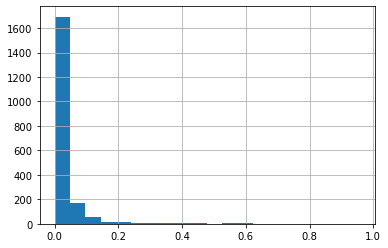

In [73]:
probas.hist(bins=20)

In [70]:
probas.max()

0.9559342640643385

In [76]:
joblib_pipeline(lr_pipe, file_name='/Users/allisonhonold/ds0805/walk_proj/walk_risk_engine/models/lr_pipline.joblib')